**Bianca Ziliotto** \
matricola 608240

---

## Assignment 2

### Libraries

In [16]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [18]:
mode = "coarse"
num_classes = 20
#mode = "fine"
#num_classes = 100

coarse_labels = np.array([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3,
                          3, 14,  9, 18,  7, 11,  3,  9,  7, 11,
                          6, 11,  5, 10,  7,  6, 13, 15,  3, 15,
                          0, 11,  1, 10, 12, 14, 16,  9, 11,  5,
                          5, 19,  8,  8, 15, 13, 14, 17, 18, 10,
                          16, 4, 17,  4,  2,  0, 17,  4, 18, 17,
                          10, 3,  2, 12, 12, 16, 12,  1,  9, 19,
                          2, 10,  0,  1, 16, 12,  9, 13, 15, 13,
                          16, 19,  2,  4,  6, 19,  5,  5,  8, 19,
                          18,  1,  2, 15,  6,  0, 17,  8, 14, 13])

### Dataset
Load CIFAR-10 dataset, which consists of 50000 training imagaes and 10000 test images, each of 32x32 pixels.

In [4]:
train_dataset = torchvision.datasets.CIFAR100(root = "..",
                             train = True,
                             transform = transform,
                             download = True)

test_dataset = torchvision.datasets.CIFAR100(root='..',
                                            train=False,
                                            transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size= 100,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size= 100,
                                          shuffle=True)

100.0%


Extracting ../cifar-100-python.tar.gz to ..


In [5]:
if mode == "fine":
  label_names = {v: k for k, v in test_loader.dataset.class_to_idx.items()}
elif mode == "coarse":
  label_names = {
      1 : "aquatic mammals",
      2 : "aquarium fish",
      3 : "flowers",
      4 : "food containers",
      5 : "fruit and vegetables",
      6 : "household electrical devices",
      7 : "household furniture",
      8 : "insects",
      9 : "large carnivores",
      10 : "large man-made outdoor things",
      11 : "large natural outdoor scenes",
      12 : "large omnivores and herbivores",
      13 : "medium-sized mammals",
      14 : "non-insect invertebrates",
      15 : "people",
      16 : "reptiles",
      17 : "small mammals",
      18 : "trees",
      19 : "vehicles 1",
      20 : "vehicles 2",
  }

### Architecture
For the architecture we partially follow the paper [1], keeping on a relatively small number of layers. In particular, we choose to implement a ResNet20. \\

We have one class for the ResNet, one for the residual block and one for the first convolutional layer.


In [6]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url = "https://miro.medium.com/v2/resize:fit:848/format:webp/1*tsMTDv-IBNlF_r4YkDBDvA.png")

We use a stack of 6 layers of 3x3 convolutions. The choice of n determines the size of our ResNet. \\

We use n=3, so we get a ResNet20. \\


The feature map sizes are {32, 16, 8} respectively with 2 convolutions for each feature map size. Also, the number of filters is {16, 32, 64} respectively.

In [7]:
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Convolutional 1**  \\
The first step on the ResNet before entering into the common layer behavior is a 3x3 convolution with a batch normalization operation. The stride is 1 and there is a padding of 1 to match the output size with the input size.

In [8]:
class FirstConvolutional(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size = (3,3)):

    super(FirstConvolutional, self).__init__()

    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):

    out = self.conv(x)
    out = self.bn(out)
    out = self.relu(out)

    return out


**Layer 1** \\
The bypass connection is a regular Identity Shortcut because the dimensionality of the volume is constant thorough the layer operations. \\
Since we chose n=1, 2 convolutions are applied within the layer 1. \\
**Layers 2 and 3** \\
For both layer 2 and next layer 3 the behavior is equivalent to layer 1, with the exception that the first convolution uses a stride of 2, and therefore the size of the output volume is half of the input volume (with the padding of 1). This implies that also the shortcut connection will require an extra step, to adjust the volumes’ sizes before the summation.
(The convolution with stride 2 is used in the skip connection for the downsample as well as in the first convolution of the layer.)

In [9]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, stride, downsample):

        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):

        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu2(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual

        out = self.relu2(out)

        return out

In [10]:
class ResNet(nn.Module):

    def __init__(self, blocks = 3, num_classes=num_classes):

      super(ResNet, self).__init__()

      self.conv = FirstConvolutional(in_channels = 3, out_channels = 16, kernel_size = (3,3))

      self.in_channels = 16

      self.layer1 = self.add_layer(out_channels = 16, blocks = blocks, stride=1)
      self.layer2 = self.add_layer(out_channels = 32, blocks = blocks, stride=2)
      self.layer3 = self.add_layer(out_channels = 64, blocks = blocks, stride=2)

      self.avg_pool = nn.AvgPool2d(8)
      self.fc = nn.Linear(64, num_classes)

    def add_layer(self, out_channels, blocks, stride):

      downsample = None

      if (stride != 1) or (self.in_channels != out_channels):
          downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=(3,3), stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels))

      layers = []
      layers.append(Block(self.in_channels, out_channels, stride = stride, downsample = downsample))
      self.in_channels = out_channels

      for i in range(1, blocks):
        layers.append(Block(out_channels, out_channels, stride = 1, downsample = None))

      return nn.Sequential(*layers)

    def forward(self, x):

      out = self.conv.forward(x)

      out = self.layer1(out)
      out = self.layer2(out)
      out = self.layer3(out)

      out = self.avg_pool(out)
      out = out.view(out.size(0), -1)
      out = self.fc(out)

      return out

### Training

After building the architecture, we train the ResNet for 60 epochs, decreasing the learning rate of a factor 3 every 20 epochs.

In [10]:
model = ResNet().to(device)

num_epochs = 60
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [11]:
total_step = len(train_loader)
total_step
train_loader

In [12]:
total_step = len(train_loader)
curr_lr = learning_rate

history = []

for epoch in range(num_epochs):

  for i, (images, labels) in enumerate(train_loader):

        if mode == "coarse":
          labels = torch.from_numpy(coarse_labels[labels])

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backpropagate and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        # Decay learning rate
        if (epoch+1) % 20 == 0:
          curr_lr /= 3
          for param_group in optimizer.param_groups:
            param_group['lr'] = curr_lr

  # Training accuracy
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in train_loader:
          if mode == "coarse":
           labels = torch.from_numpy(coarse_labels[labels])
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Accuracy of the model on the training images: {} %'.format(100 * correct / total))
      history.append(100 * correct / total)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        if mode == "coarse":
            labels = torch.from_numpy(coarse_labels[labels])
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'resnet_coarse.ckpt')
torch.save(history, 'resnet_coarse_history')

Epoch [1/60], Step [100/500] Loss: 2.5969
Epoch [1/60], Step [200/500] Loss: 2.3754
Epoch [1/60], Step [300/500] Loss: 2.1134
Epoch [1/60], Step [400/500] Loss: 2.0688
Epoch [1/60], Step [500/500] Loss: 2.4467
Accuracy of the model on the training images: 32.534 %
Epoch [2/60], Step [100/500] Loss: 2.9839
Epoch [2/60], Step [200/500] Loss: 2.9195
Epoch [2/60], Step [300/500] Loss: 2.8558
Epoch [2/60], Step [400/500] Loss: 2.6860
Epoch [2/60], Step [500/500] Loss: 2.7362
Accuracy of the model on the training images: 15.366 %
Epoch [3/60], Step [100/500] Loss: 2.6549
Epoch [3/60], Step [200/500] Loss: 2.4821
Epoch [3/60], Step [300/500] Loss: 2.4946
Epoch [3/60], Step [400/500] Loss: 2.6225
Epoch [3/60], Step [500/500] Loss: 2.4572
Accuracy of the model on the training images: 21.718 %
Epoch [4/60], Step [100/500] Loss: 2.4413
Epoch [4/60], Step [200/500] Loss: 2.3625
Epoch [4/60], Step [300/500] Loss: 2.2675
Epoch [4/60], Step [400/500] Loss: 2.2623
Epoch [4/60], Step [500/500] Loss: 2.

In [13]:
torch.save(model.state_dict(), 'resnet_coarse.ckpt')
torch.save(history, 'resnet_coarse_history')

### Results

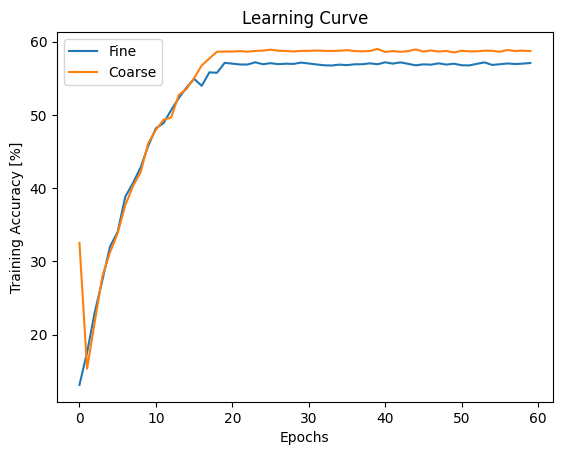

In [2]:
history_coarse = torch.load('models/resnet_coarse_history')
history = torch.load('models/resnet_history')

fig, ax = plt.subplots()
ax.plot(history, label = "Fine")
ax.plot(history_coarse, label = "Coarse")
ax.set_xlabel("Epochs")
ax.set_ylabel("Training Accuracy [%]")
ax.set_title("Learning Curve")
ax.legend()


In [11]:
model = ResNet()
model.load_state_dict(torch.load('models/resnet_coarse.ckpt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [23]:
labels_all = []
predicted_all = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        if mode == "coarse":
            labels = torch.from_numpy(coarse_labels[labels])
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        labels_all.append(labels[0])
        predicted_all.append(predicted[0])

cm = confusion_matrix(np.array(labels_all), np.array(predicted_all), normalize='true')

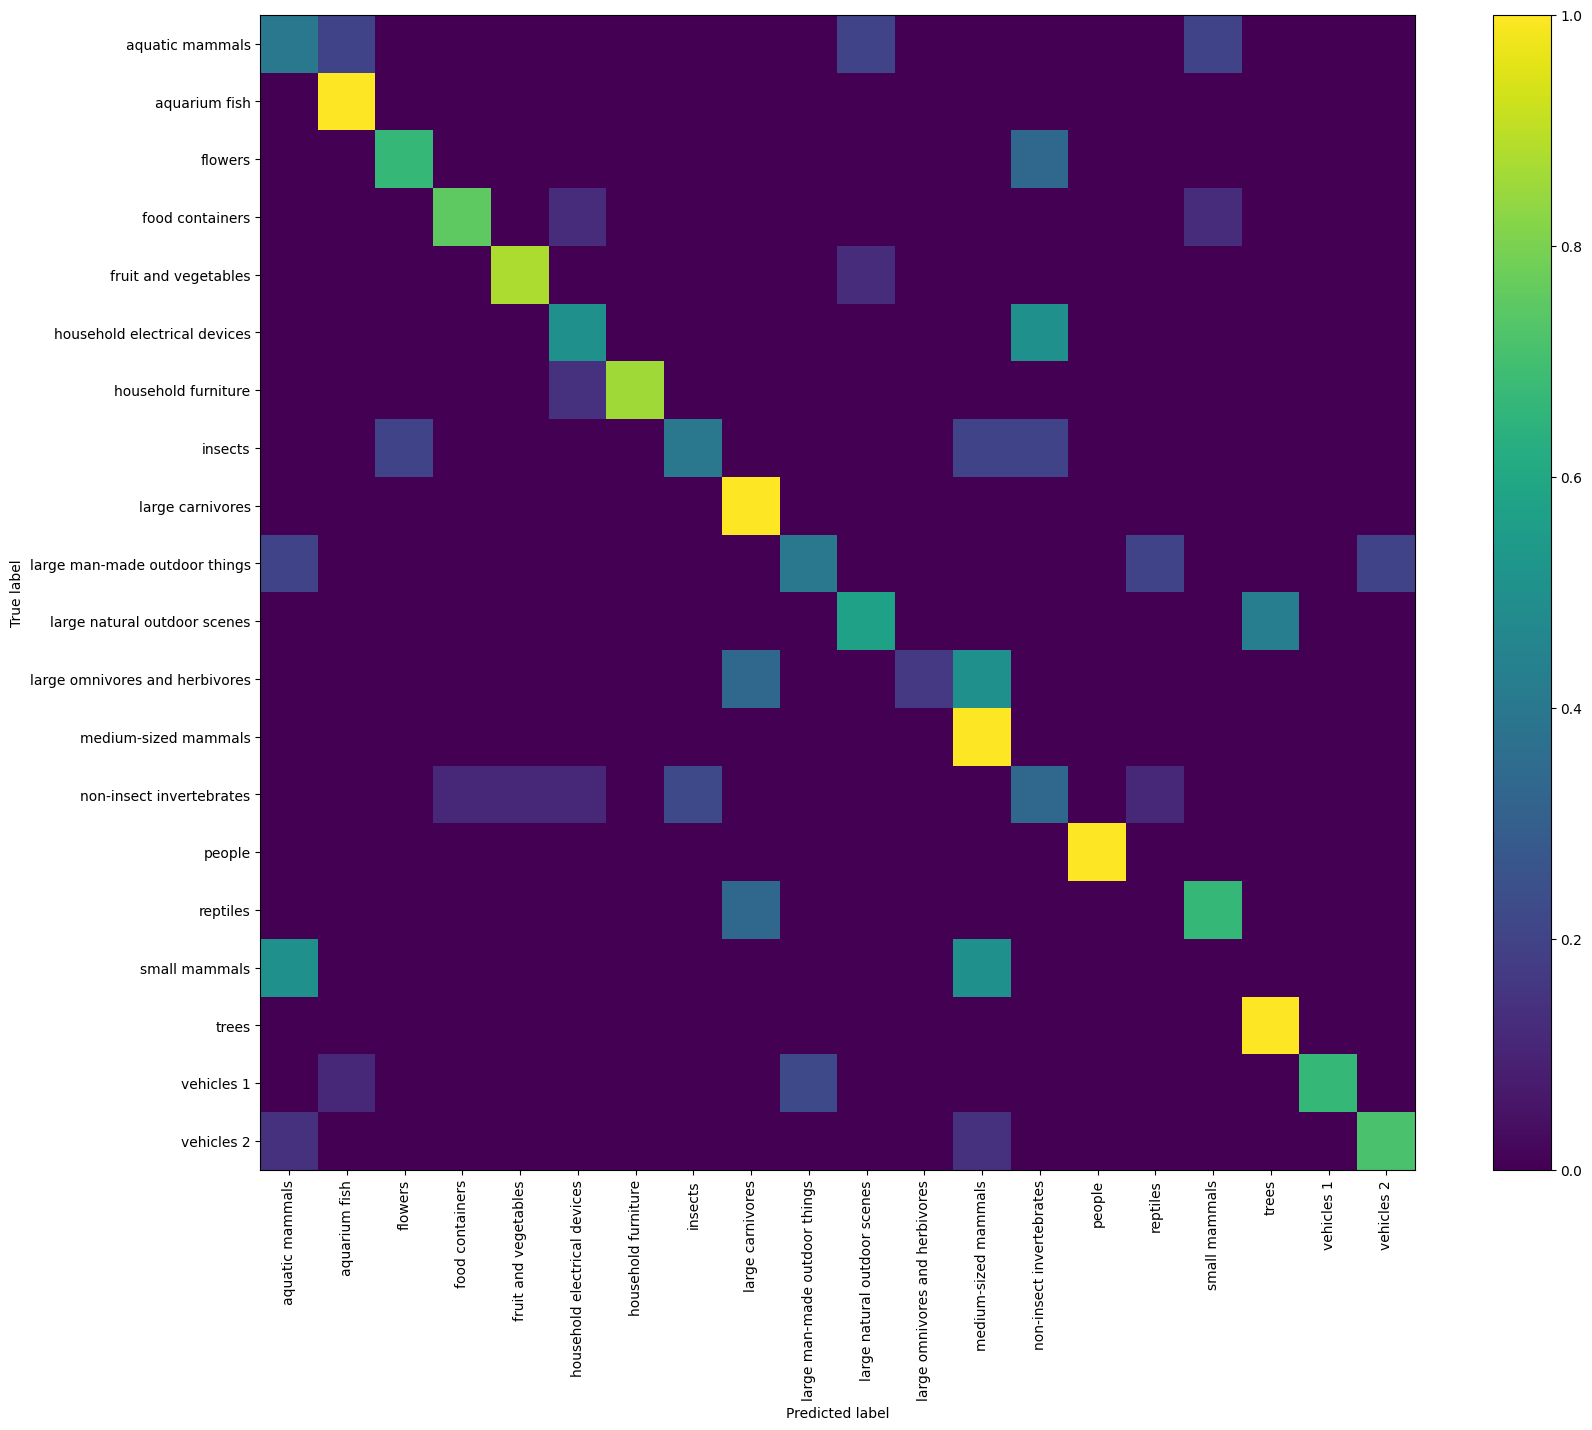

In [24]:
fig, axs = plt.subplots(figsize = (20, 15))
disp = ConfusionMatrixDisplay(cm, display_labels = label_names.values())
disp.plot(xticks_rotation = "vertical", include_values = False, ax = axs)
plt.show()

### References

[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. Deep Residual Learning for Image Recognition.
https://doi.org/10.48550/arXiv.1512.03385
